In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Classifiers 
from sklearn.ensemble import ExtraTreesClassifier


# Analysis libs
from itertools import cycle
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [6]:
etc = ExtraTreesClassifier(n_estimators=malware_data.shape[1], random_state=42)
clf = etc.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 0.9998537191896043
Test accuracy: 0.8582968314466124


In [7]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall score: {recall_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"F-1 score: {f1_score(y_test, y_pred, average='weighted', zero_division=0)}")

Accuracy score: 0.8582968314466124
Precision score: 0.8583205526720756
Recall score: 0.8582968314466124
F-1 score: 0.8582778886495194


In [8]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8790,    0,    0,    0],
       [   0, 2011,  410,  516],
       [   0,  368, 2264,  374],
       [   0,  491,  332, 2023]], dtype=int64)

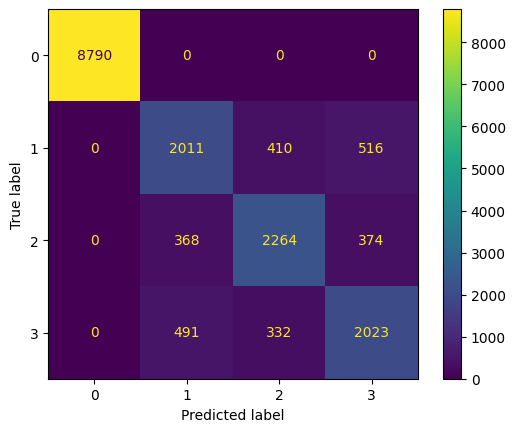

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       0.70      0.68      0.69      2937
           2       0.75      0.75      0.75      3006
           3       0.69      0.71      0.70      2846

    accuracy                           0.86     17579
   macro avg       0.79      0.79      0.79     17579
weighted avg       0.86      0.86      0.86     17579



In [11]:
scores = cross_val_score(clf, X, y, cv=10)

In [12]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.7605802  0.78617747 0.82406143 0.83993174 0.86569966 0.84010239
 0.83922171 0.82778631 0.79194402 0.80030722]
Mean of CV scores: 0.8175812160283151
Standard Deviation of CV scores: 0.030211833856993466


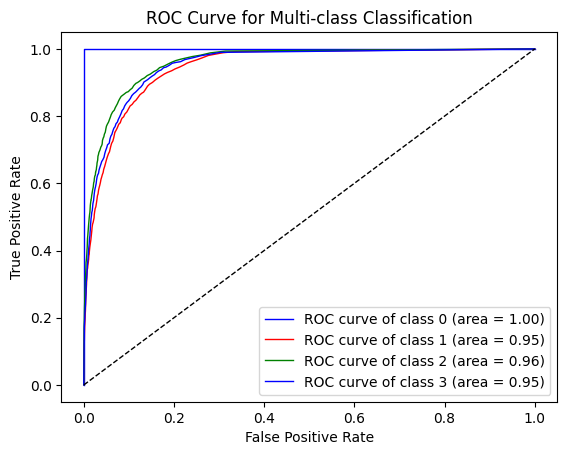

In [13]:
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

classifier = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=100, random_state=42))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

### Report and results
In using the model ExtraTrees, we can see that this model does decently well in this task. Like the other RandomForest this model is able to define benign samples quite well, but the other classes are not as well defined. However, according to the confusion matrix this model does define the other classes decently and we can further confirm this with the ROC graphic. According to the scores, we can see that each metric is at least 0.85 meriting a decent model to work with.